In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy.io as sio

In [2]:
data = sio.loadmat('LVsVersusSubtendedAngle.mat')

In [3]:
clean_dict = {'lv': np.squeeze(data['LVs']), 'resp_angle': np.squeeze(data['subtendedAngleAtResponse'])}
df = pd.DataFrame(clean_dict)
df.describe()

,lv,resp_angle
count,246.000000,246.000000
mean,0.694752,43.558036
std,0.308021,27.765487
min,0.100000,14.290141
25%,0.451914,28.034274
50%,0.714518,34.141328
75%,0.971854,46.764871
max,1.195086,169.885266


In [4]:
import delfi
from delfi.simulator import GaussMixture
from delfi.simulator.BaseSimulator import BaseSimulator
from delfi.inference import SNPE
import delfi.distribution as dd
from delfi.summarystats import Identity
from delfi.generator import Default
from delfi.generator import MPGenerator
from delfi.utils import viz

import models as md

In [20]:
class LIF(BaseSimulator):
    def __init__(self, dim=1, seed=None, fixed_params=None):
        """Leaky Integrate-and-Fire simulator
        Integrates input until a given threshold is reached at which we
        define the response time.
        Parameters
        ----------
        dim : int
            Number of dimensions of parameters
        noise_cov : list
            Covariance of noise on observations
        seed : int or None
            If set, randomness is seeded
        """
        super().__init__(dim_param=dim, seed=seed)
        self.fixed_params = fixed_params

    @copy_ancestor_docstring
    def gen_single(self, param):
        # See BaseSimulator for docstring
        param = np.asarray(param).reshape(-1)
        assert param.ndim == 1
        assert param.shape[0] == self.dim_param

        model_params = self.fixed_params.copy()
        model_params['m'] = param[0]
        model_params['noise_std'] = param[1]*1e-3
        model_params['vt_std'] = param[2]*1e-3
        nruns = 246
        rstims = np.zeros((1, nruns))
        lvs = np.zeros((1, nruns))
        for i in np.arange(nruns):
            rstims[0, i], rdist, reaction_time, lvs[0, i], stim_size, speed, rtime_to_coll = md.calc_response(model_params)

        data = np.concatenate((rstims, lvs), axis=1)
        return {'data': data}

In [71]:
total_time = 5
dt = 0.001
params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6,
          'v_t': -0.061,
          'init_vm_std': 0.000,
          'vt_std': 0.000,
          'dt': dt,
          'total_time': total_time,
          'init_period': 0,
          'noise_std': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 5,
          'b': 0,
          'cutoff_angle': 180}

lifm = LIF(dim=3, fixed_params=params)

# params are: m, noise_std, vt_std
p = dd.Uniform(lower=[1, 0, 0], upper=[8, 10, 5])
s = Identity()
#g = Default(model=lifm, prior=p, summary=s)
g = MPGenerator(models=[lifm]*5, prior=p, summary=s)

A Jupyter Widget

A Jupyter Widget

Text(0.5,1,'m = [7.71154685 9.82258776 0.6823266 ]')

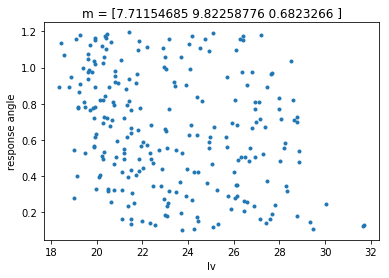

In [72]:
gparams, stats = g.gen(100)
plt.plot(stats[0, 0:246], stats[0, 246:], '.')
plt.ylabel(r'response angle')
plt.xlabel(r'lv')
plt.title('m = ' + str(gparams[0]))

In [73]:
expm_data = np.concatenate((clean_dict['resp_angle'], clean_dict['lv'])).reshape((1, 492))
expm_data.shape

(1, 492)

In [214]:
n_hidden_values = [[10], [100], [500], [100]*3, [100]*5]
n_train_values = [[500], [1000], [500, 200], [1000, 200], [500, 200, 200], [200, 200, 200]]
n_rounds_values = [len(vals) for vals in n_train_values]
epochs_values = [100, 500]

In [215]:
def run_fit(n_hiddens, n_train, n_rounds, epochs):
    inf_snpe = SNPE(generator=g, n_components=1, n_hiddens=n_hiddens, obs=expm_data, verbose=False)
    logs, tds, posteriors = inf_snpe.run(n_train=n_train, n_rounds=n_rounds, epochs=epochs)
    posterior = posteriors[-1]
    return logs, posterior

In [206]:
logs_list = [[[] for i in range(len(n_train_values))] for j in range(len(n_hidden_values))]
print(logs_list)

[[[], []], [[], []], [[], []], [[], []], [[], []]]


In [216]:
logs_list = [[[] for i in range(len(n_train_values))] for j in range(len(n_hidden_values))]
posterior_list = [[[] for i in range(len(n_train_values))] for j in range(len(n_hidden_values))]
for n_hidden_idx, n_hidden_val in enumerate(n_hidden_values):
    for n_train_idx, (n_train_val, n_rounds_val) in enumerate(zip(n_train_values, n_rounds_values)):
        for epochs_val in epochs_values:
            logs, posterior = run_fit(n_hidden_val, n_train_val, n_rounds_val, epochs_val)
            logs_list[n_hidden_idx][n_train_idx].append(logs)
            posterior_list[n_hidden_idx][n_train_idx].append(posterior)

In [217]:
len(logs_list)

5

In [219]:
def plot_losses(logs):
    for log_idx, log in enumerate(logs):
        plt.figure()
        plt.plot(log['loss'])
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Round ' + str(log_idx+1))
        
def plot_pdfs(posterior):
    lims = np.array([[0, 8],[0, 10], [0, 5]])
    viz.plot_pdf(posterior.xs[0], lims=lims, labels_params=['m', 'noise_std', 'vt_std'],
                 figsize=(12,12), ticks=True);
    
def plot_fitting_results(logs, posterior):
    plot_losses(logs)
    plot_pdfs(posterior)

In [256]:
n_hidden

[[10], [100], [500], [100, 100, 100], [100, 100, 100, 100, 100]]

In [298]:
data_cols = ['n_hidden', 'n_train', 'n_rounds', 'n_epochs', 'mean_m', 'mean_noise', 'mean_vt_std',
             'std_m', 'std_noise', 'std_vt_std', 'final_loss']
data_dict = dict([(col_name, []) for col_name in data_cols])
for n_hidden_idx, n_hidden_val in enumerate(n_hidden_values):
    for n_train_idx, n_train_val in enumerate(n_train_values):
        for epochs_idx, epochs_val in enumerate(epochs_values):
            cposterior = posterior_list[n_hidden_idx][n_train_idx][epochs_idx]
            clogs = logs_list[n_hidden_idx][n_train_idx][epochs_idx]
            cmeans = cposterior.mean
            cstds = cposterior.std
            closs = int(10*np.log(clogs[-1]['loss'][-1]))
            result_values = [str(n_hidden_val), str(n_train_val), len(n_train_val), epochs_val, cmeans[0], cmeans[1],
                             cmeans[2], cstds[0], cstds[1], cstds[2], closs]
            for col, value in zip(data_cols, result_values):
                data_dict[col].append(value)

df = pd.DataFrame(data_dict)

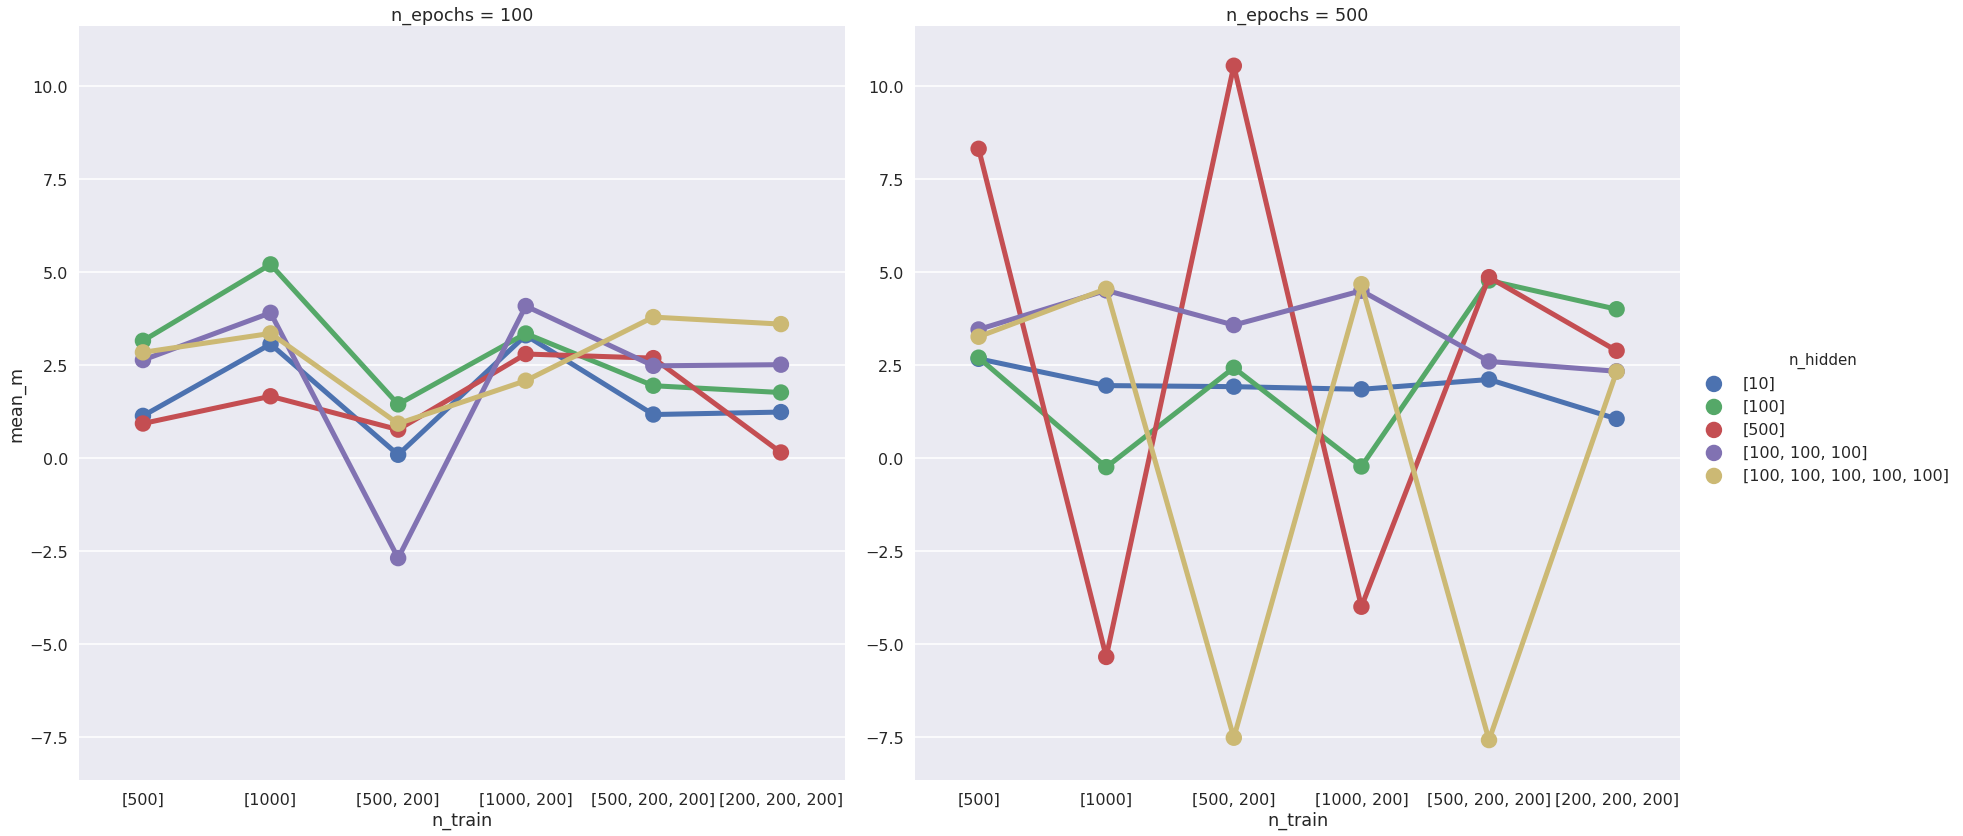

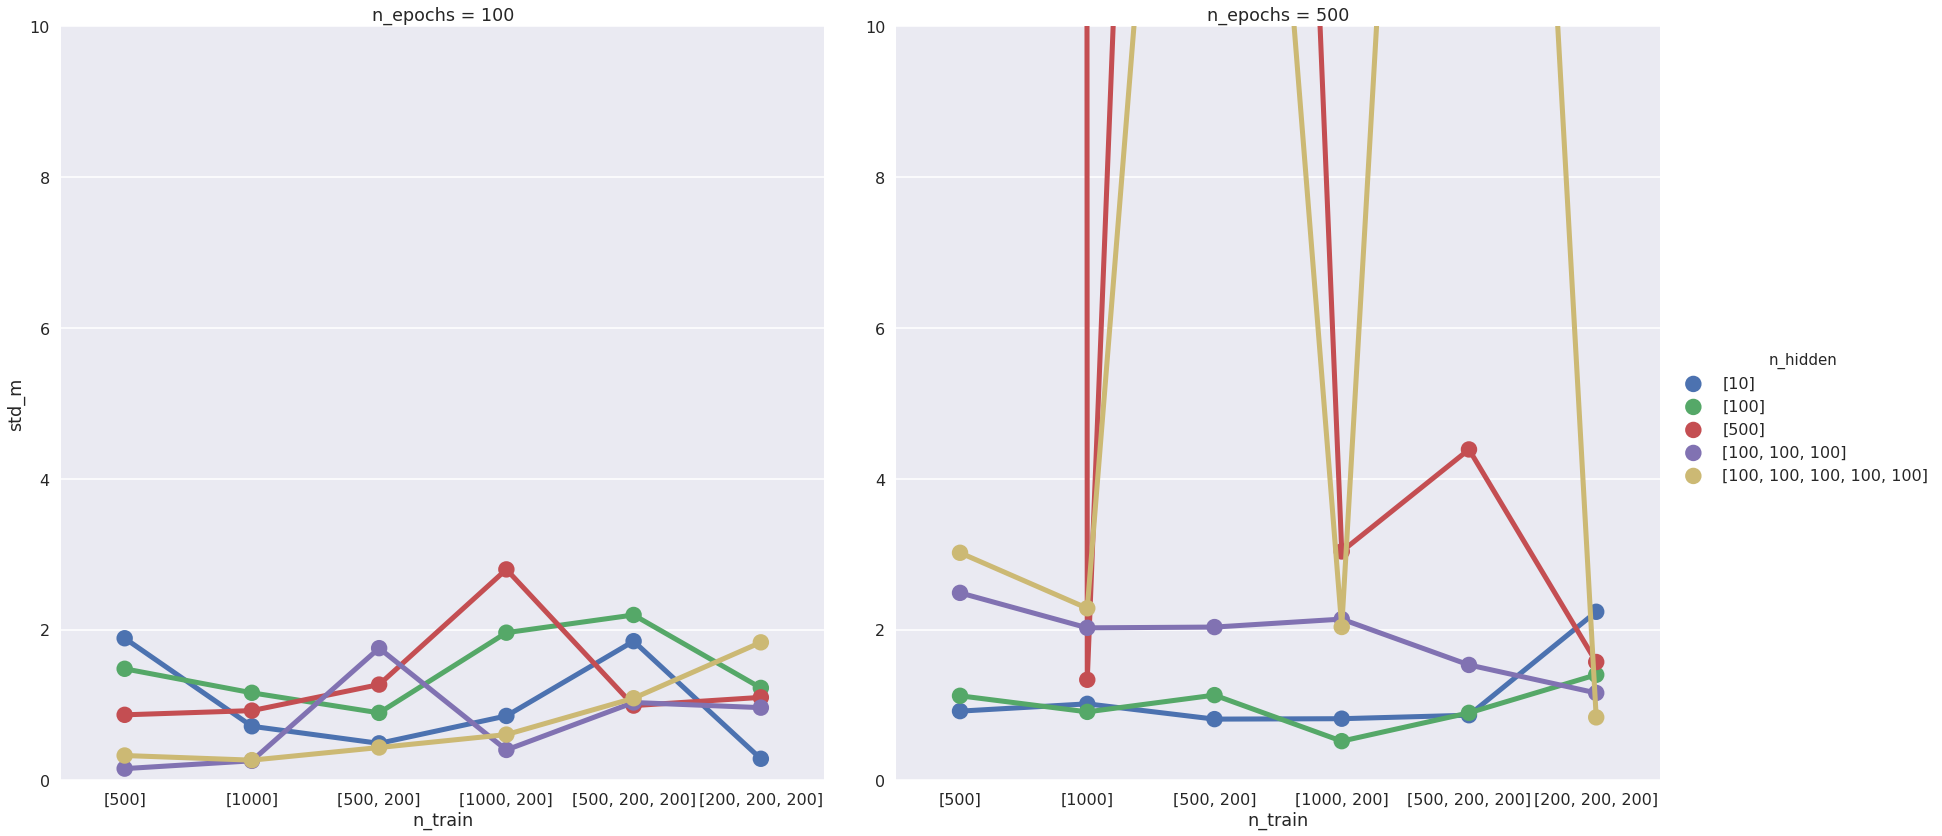

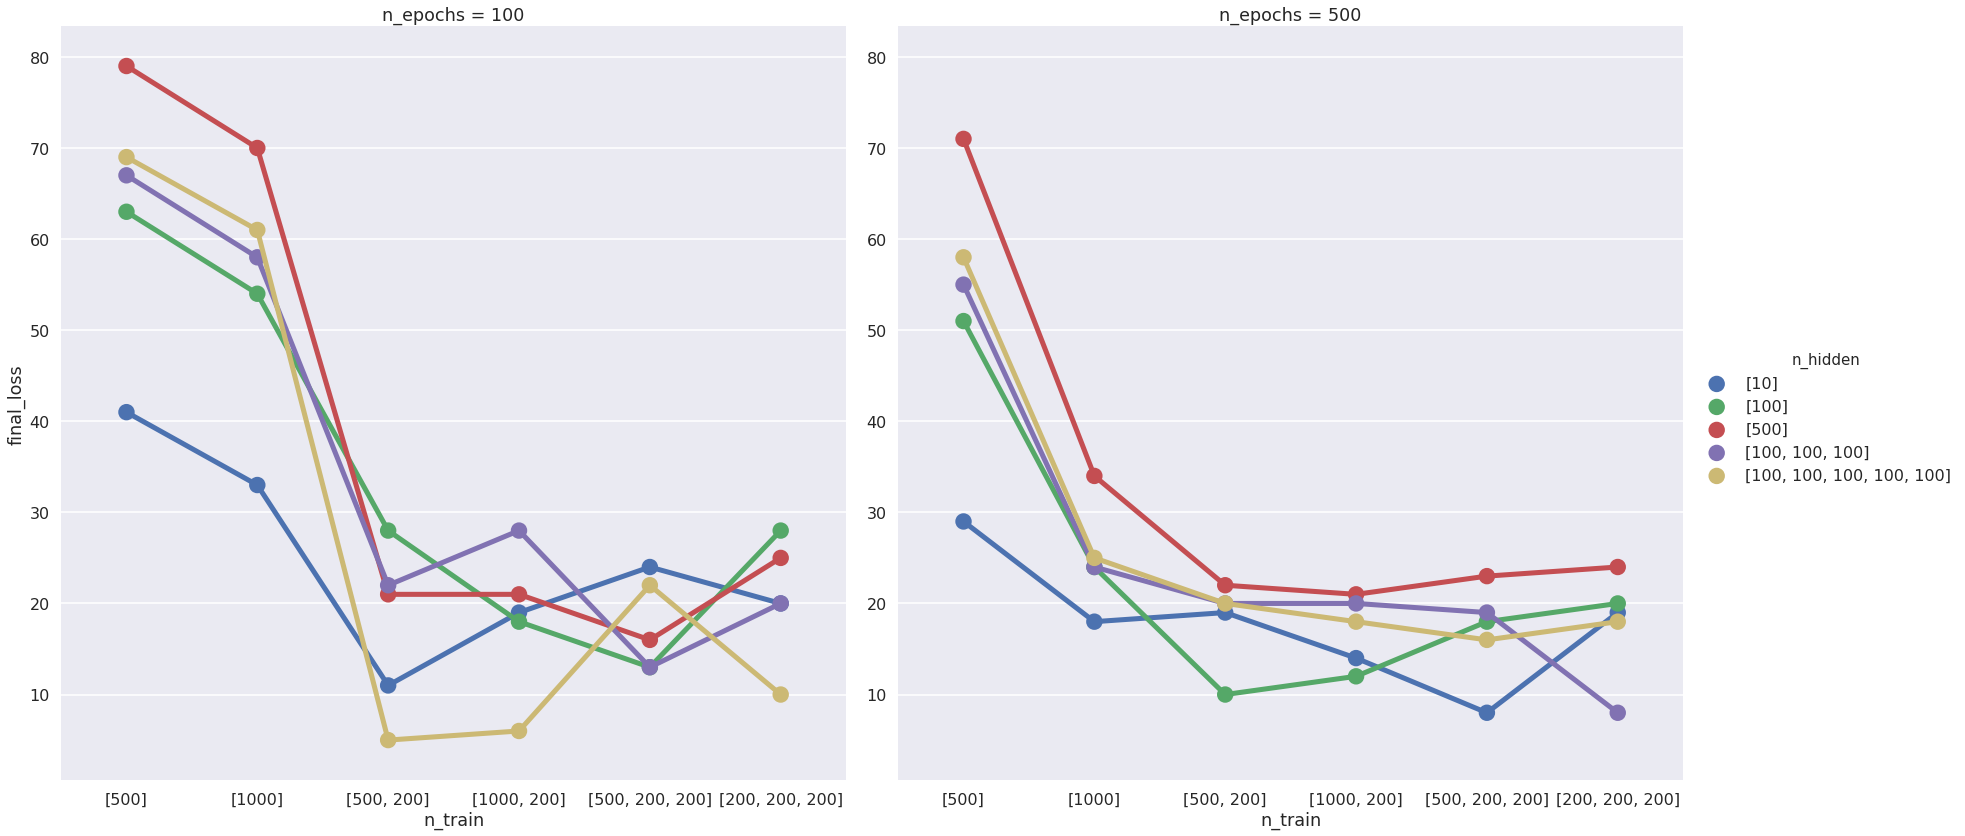

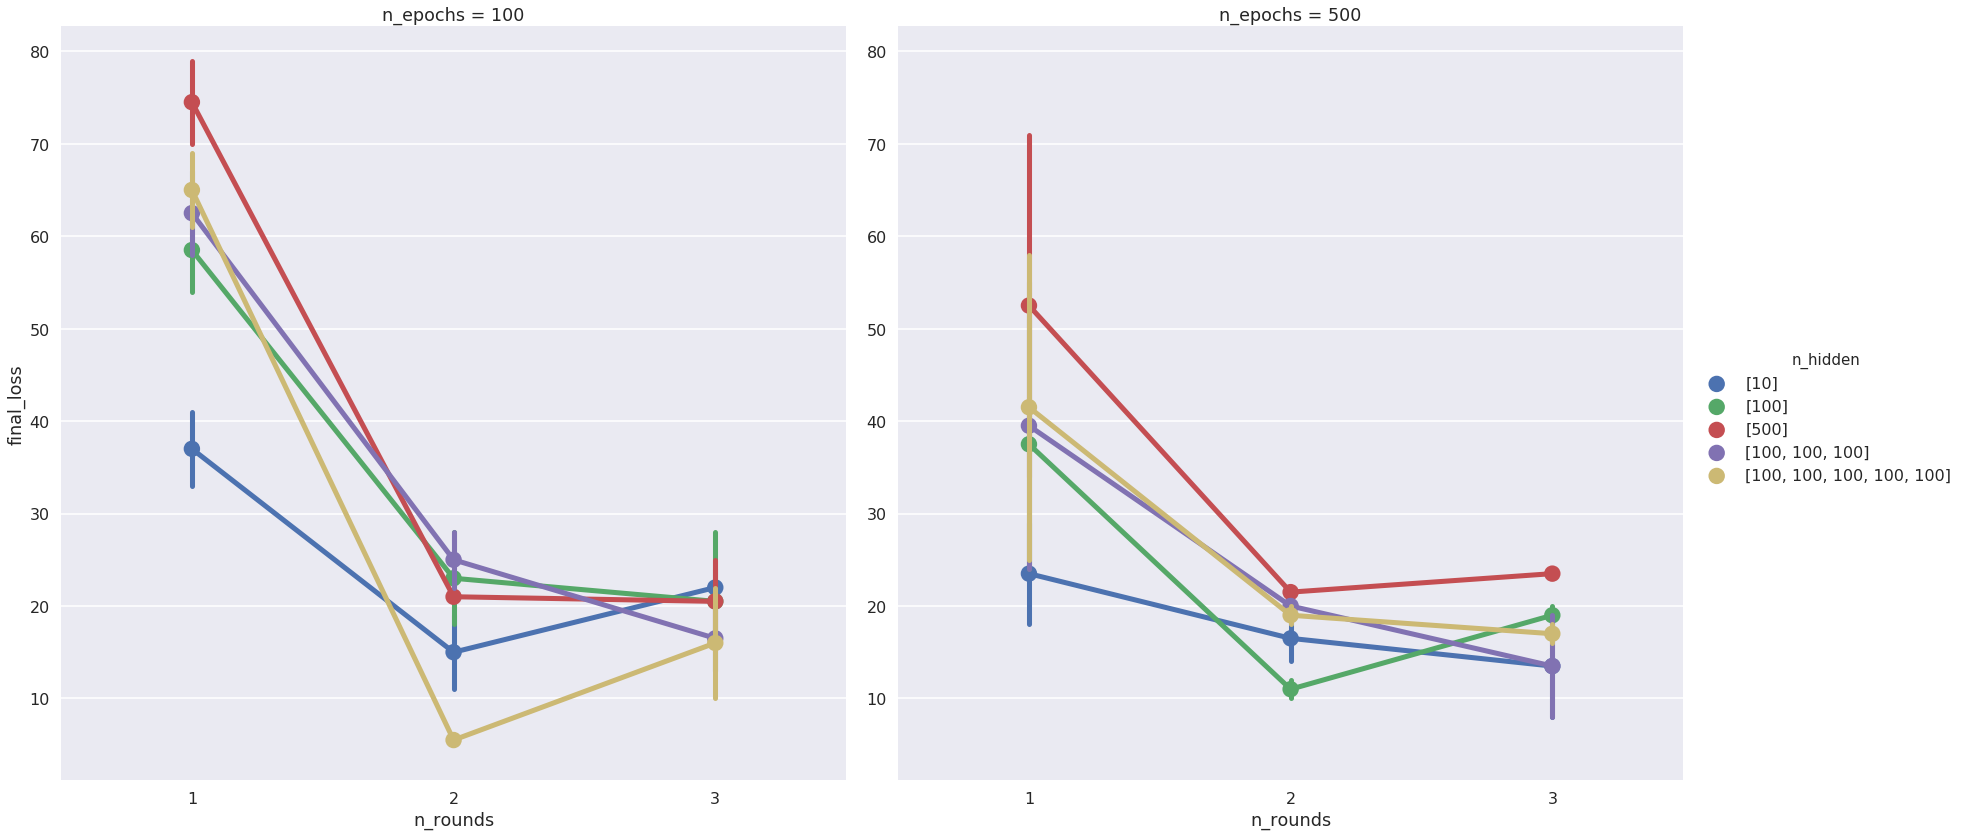

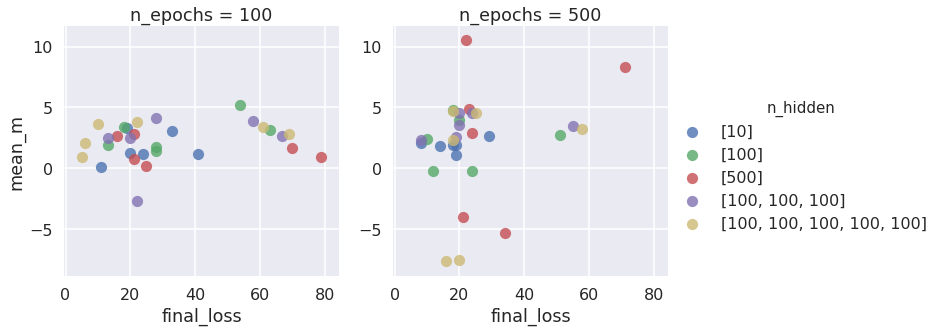

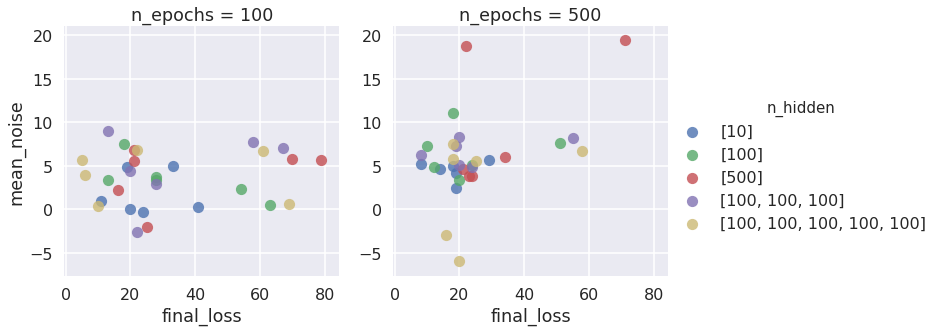

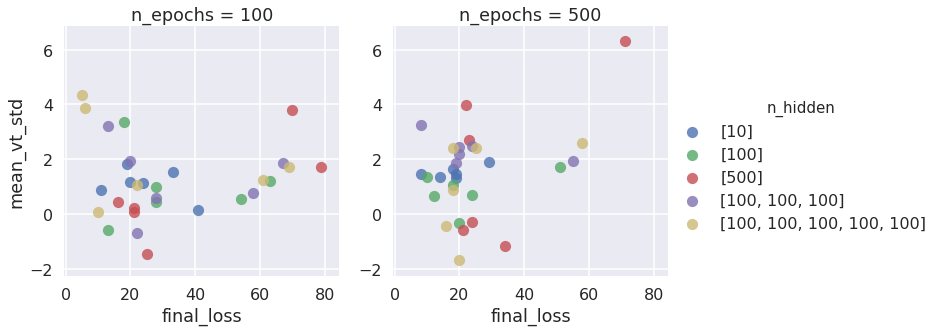

In [300]:
sns.set('poster')
sns.factorplot(x='n_train', y='mean_m', hue='n_hidden', col='n_epochs', kind='point', data=df, size=12)
sns.factorplot(x='n_train', y='std_m', hue='n_hidden', col='n_epochs', kind='point', data=df, size=12)
plt.ylim([0,10])
grid = sns.factorplot(x='n_train', y='final_loss', hue='n_hidden', col='n_epochs', kind='point', data=df, size=12)
grid = sns.factorplot(x='n_rounds', y='final_loss', hue='n_hidden', col='n_epochs', kind='point', data=df, size=12)
grid = sns.factorplot(x='n_epochs', y='final_loss', hue='n_hidden', col='n_train', kind='point', data=df, size=12)
#grid.set(yscale='log')
grid = sns.lmplot(x='final_loss', y='mean_m', hue='n_hidden', col='n_epochs', fit_reg=False, data=df)
grid = sns.lmplot(x='final_loss', y='mean_noise', hue='n_hidden', col='n_epochs', fit_reg=False, data=df)
grid = sns.lmplot(x='final_loss', y='mean_vt_std', hue='n_hidden', col='n_epochs', fit_reg=False, data=df)
#grid.set(yscale='log')

/home/warkentin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


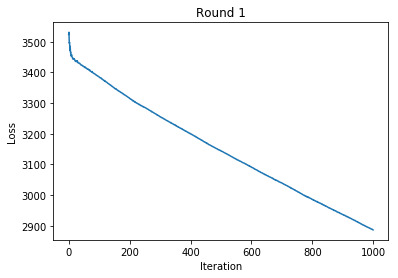

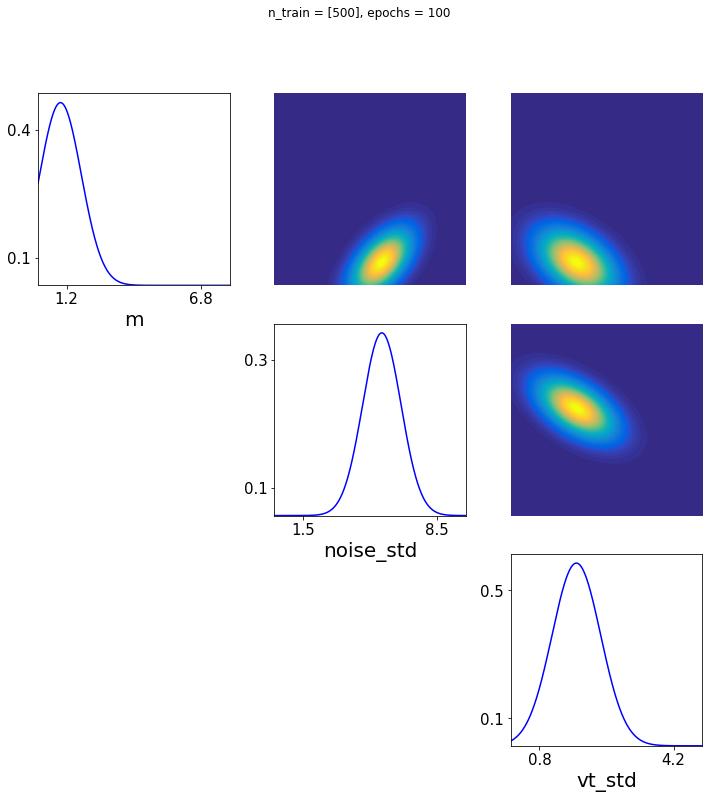

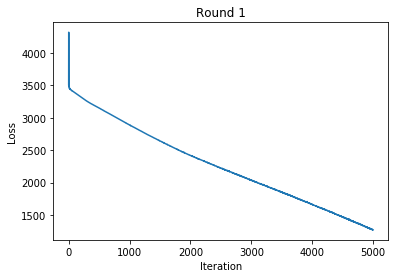

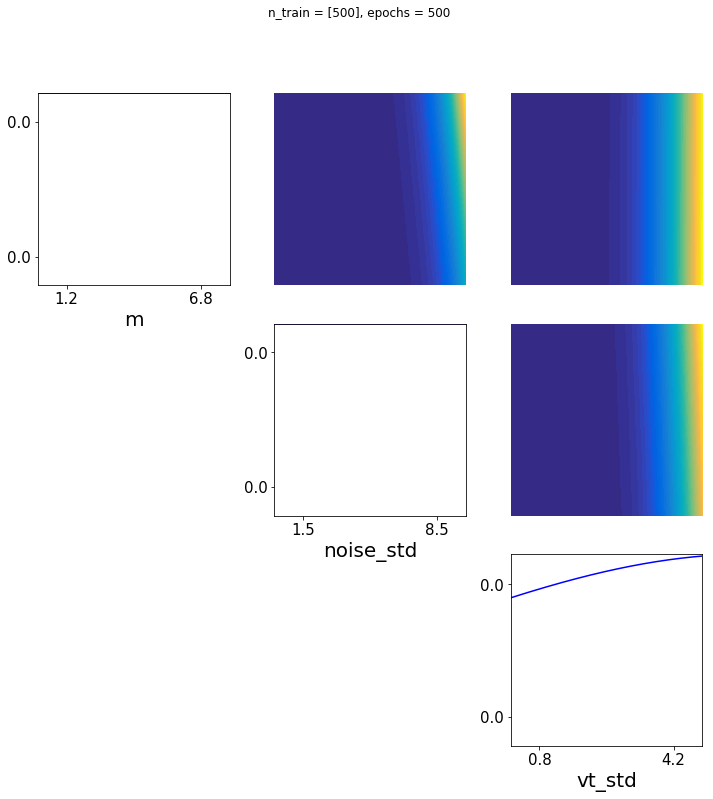

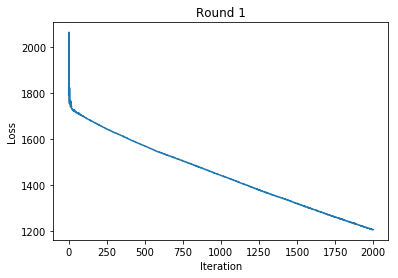

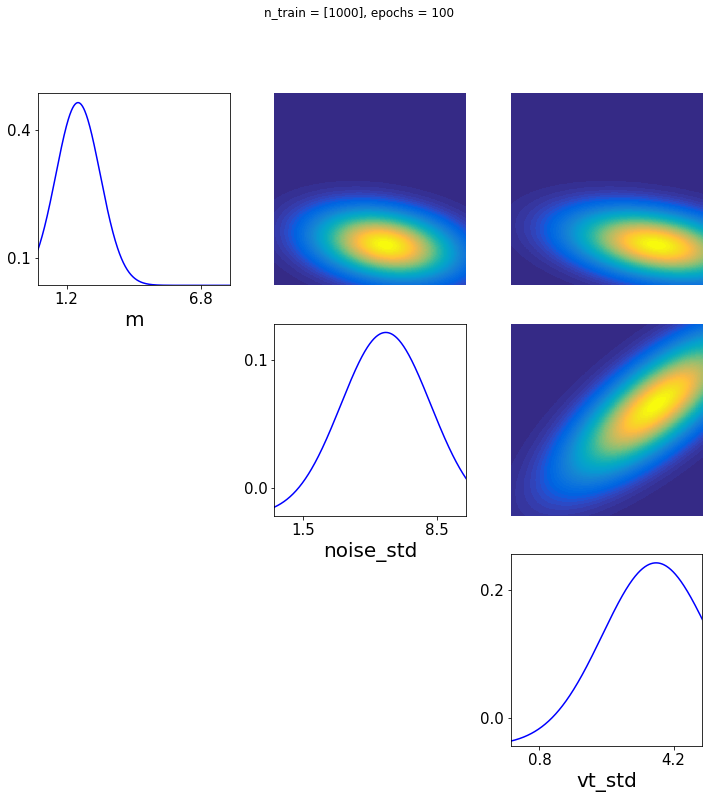

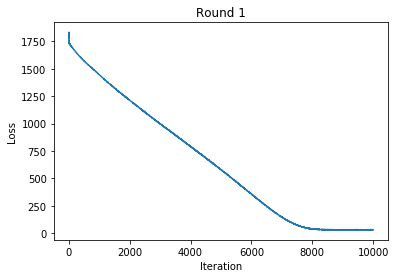

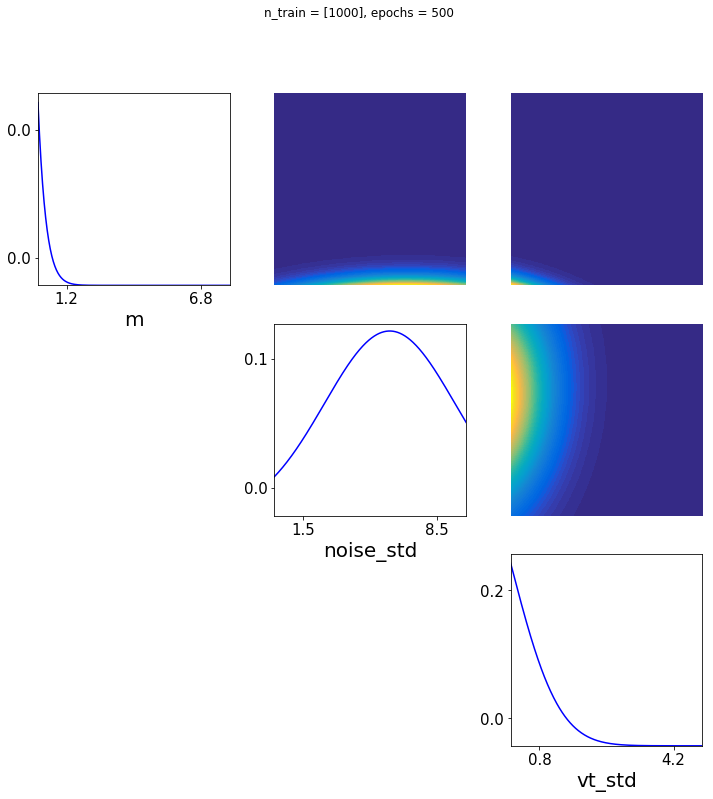

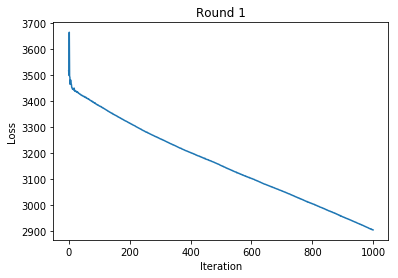

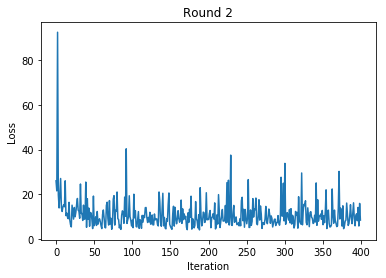

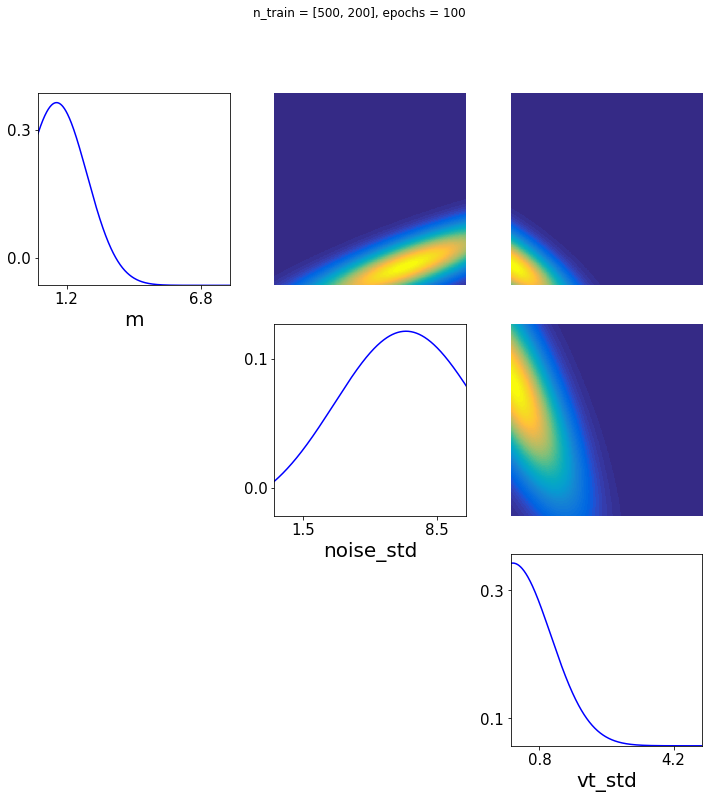

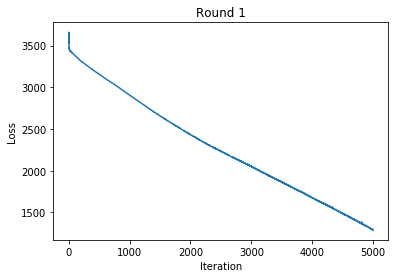

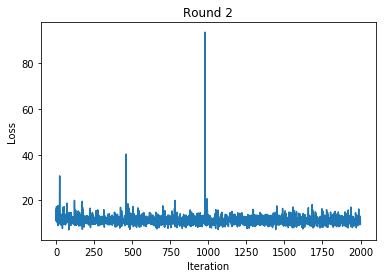

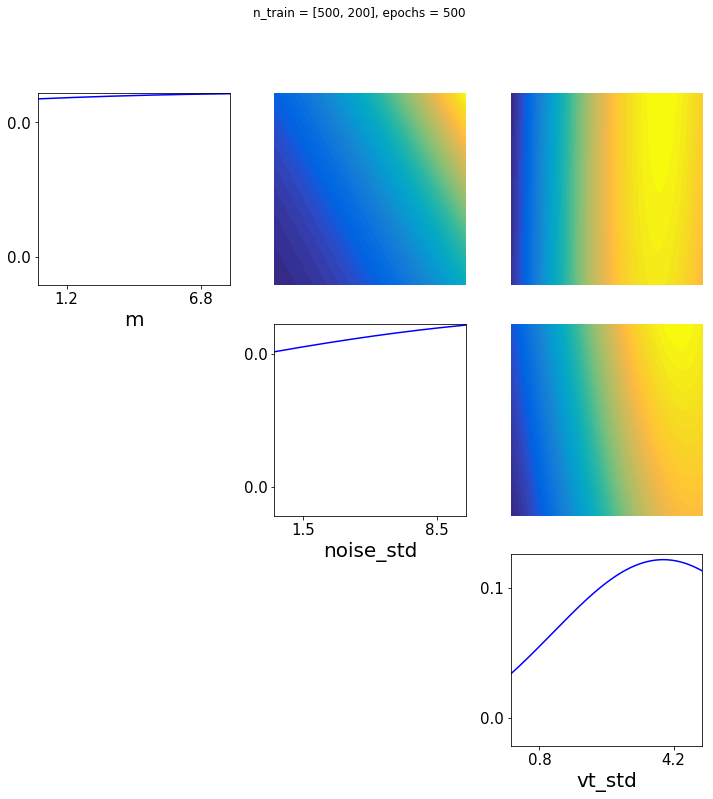

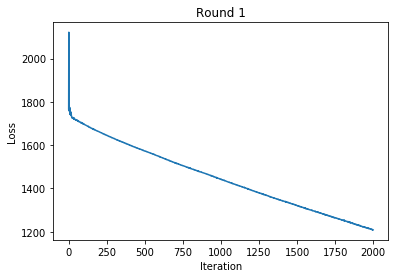

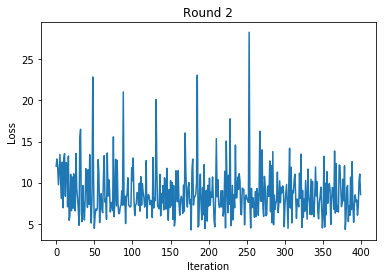

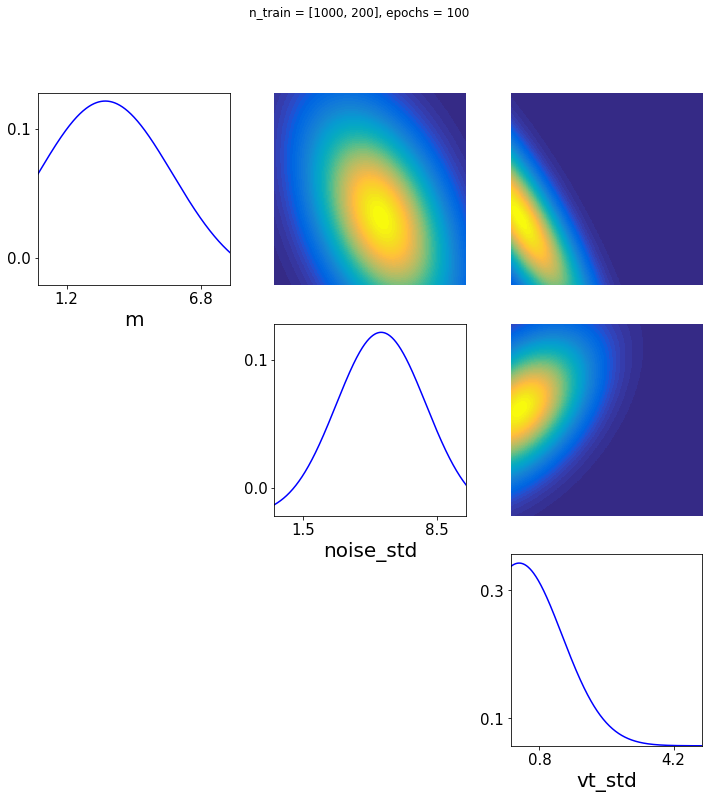

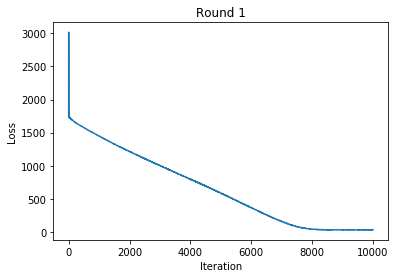

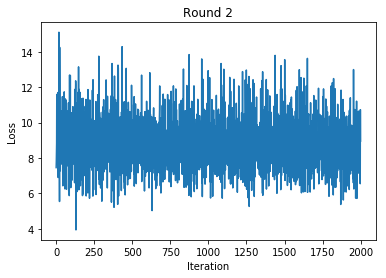

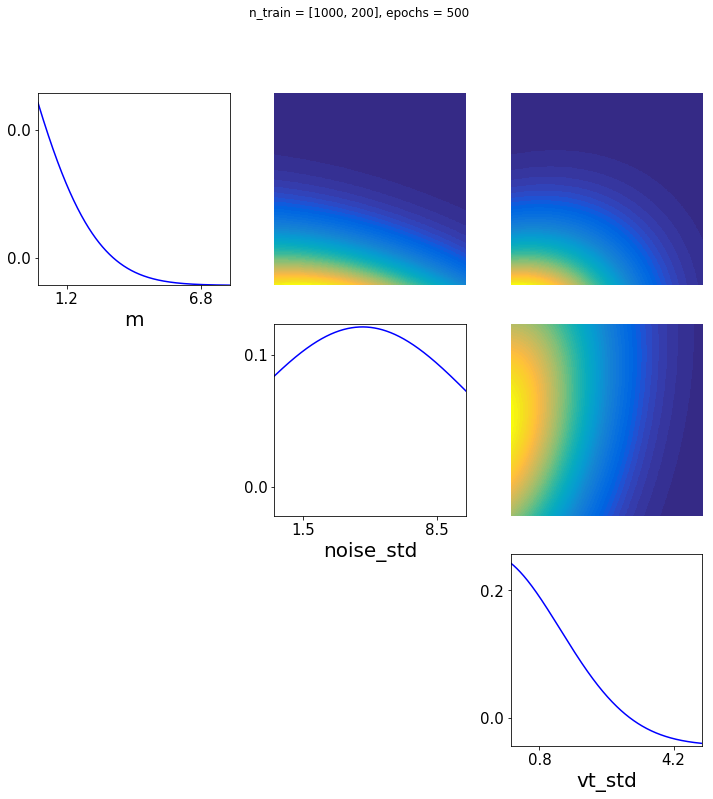

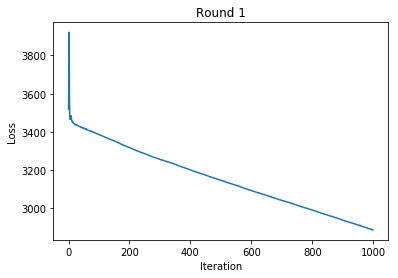

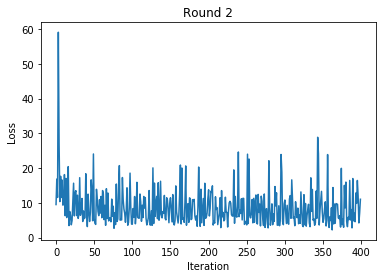

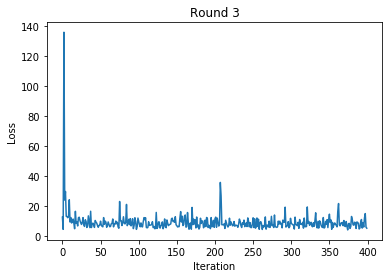

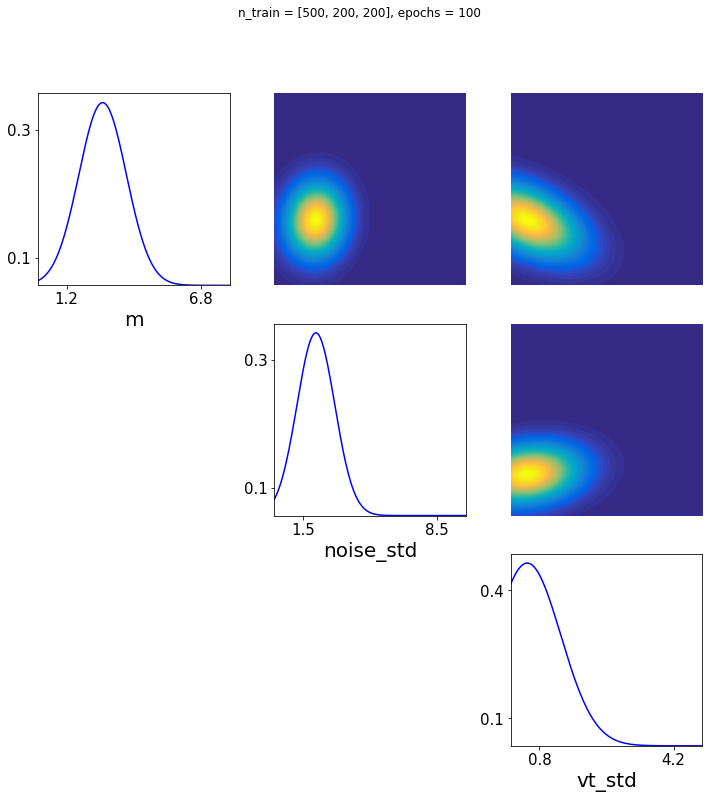

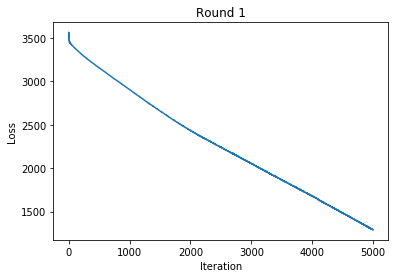

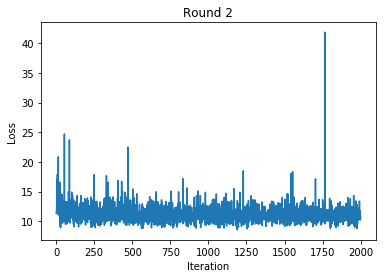

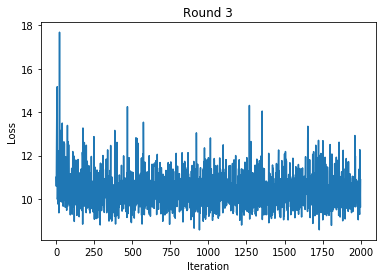

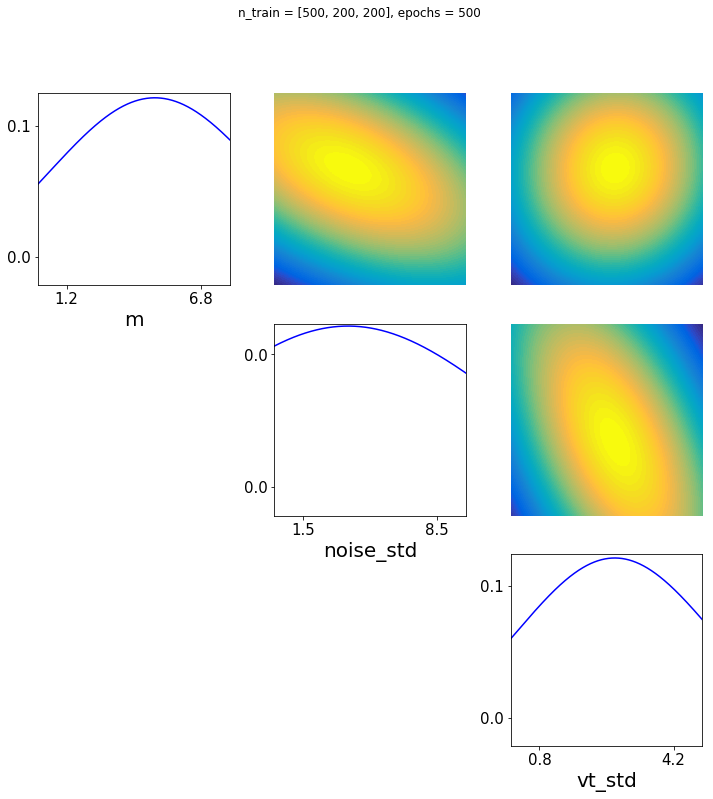

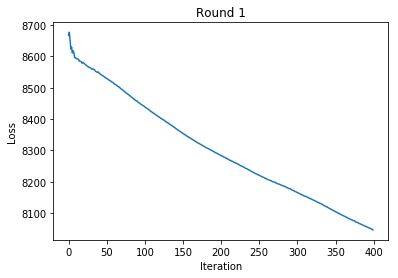

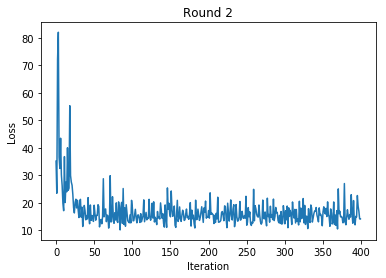

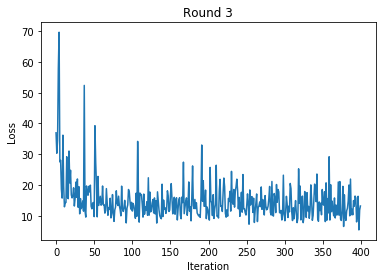

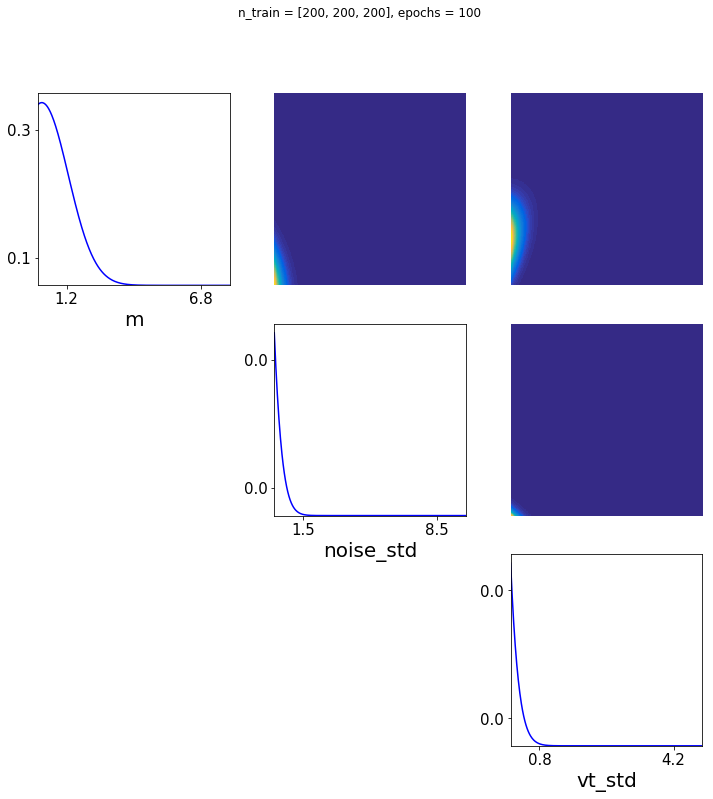

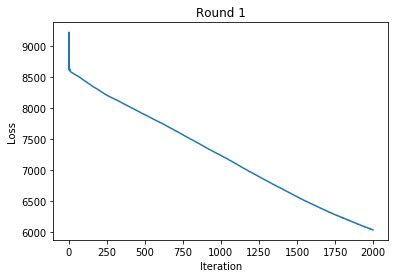

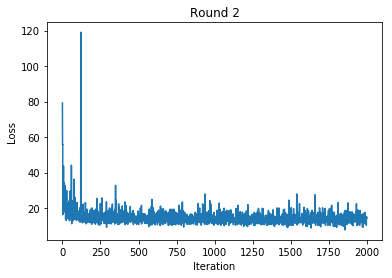

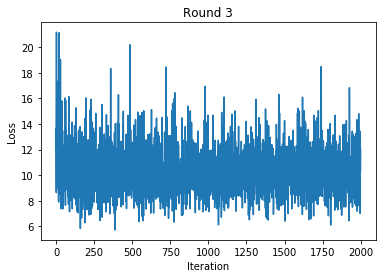

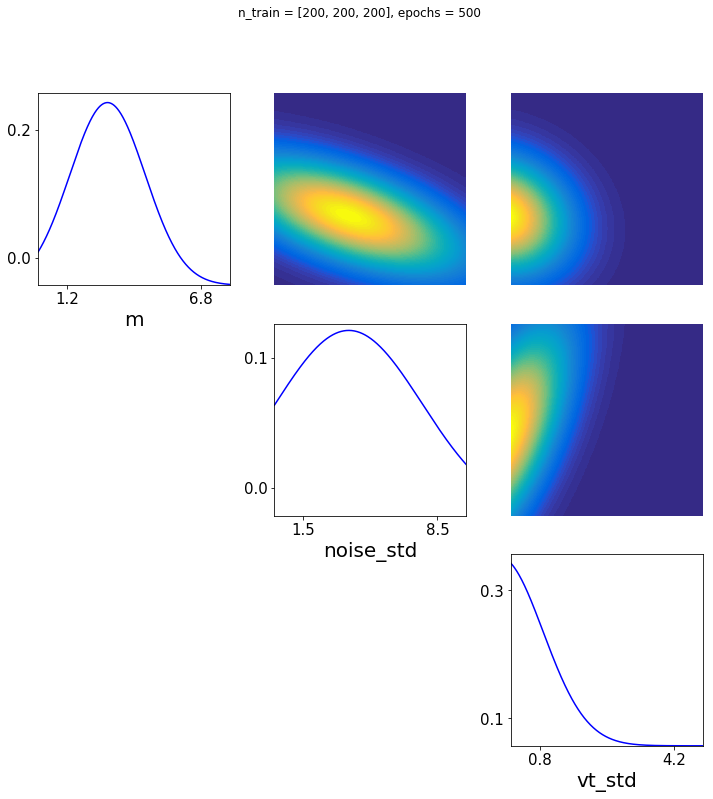

In [243]:
for n_train_idx, n_train_val in enumerate(n_train_values):
    for epochs_idx, epochs_val in enumerate(epochs_values):
        plot_fitting_results(logs_list[2][n_train_idx][epochs_idx], posterior_list[2][n_train_idx][epochs_idx])
        plt.suptitle('n_train = ' + str(n_train_val) + ', epochs = ' + str(epochs_val))

In [188]:


inf_snpe = SNPE(generator=g, n_components=1, n_hiddens=[50, 50, 50], obs=expm_data, verbose=False)
logs, tds, posteriors = inf_snpe.run(n_train=[500, 200, 200], n_rounds=3, epochs=1000)
posterior = posteriors[-1]

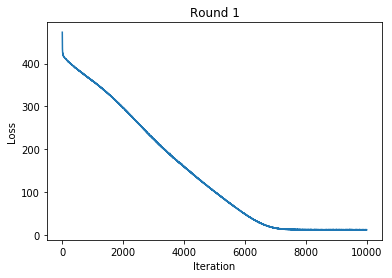

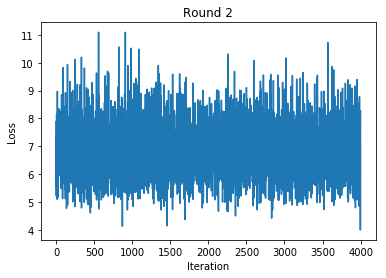

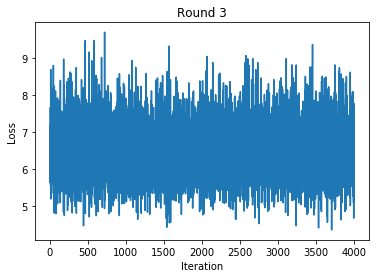

In [189]:
for log_idx, log in enumerate(logs):
    plt.figure()
    plt.plot(log['loss'])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Round ' + str(log_idx+1))

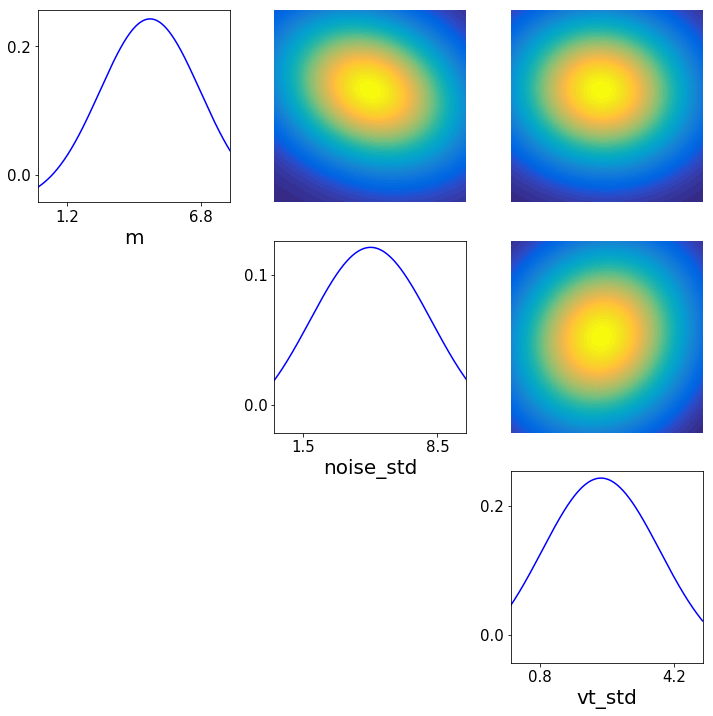

In [190]:
lims = np.array([[0, 8],[0, 10], [0, 5]])
viz.plot_pdf(posterior.xs[0], lims=lims, labels_params=['m', 'noise_std', 'vt_std'],
             figsize=(12,12), ticks=True);

In [265]:
posterior.std

array([ 1.58511074,  6.43638483,  5.21072001, 13.02542898,  2.43390069])

In [118]:
mog1 = posterior.xs[0]
mog1.C

array([[ 2.12833027, -0.41441998, -0.21905204],
       [ 0.        ,  3.30991522, -0.59642641],
       [ 0.        ,  0.        ,  1.5482229 ]])

## Feedforward inhibition model

In [226]:
class FFI(BaseSimulator):
    def __init__(self, dim=1, seed=None, fixed_params=None):
        """Feedforward inhibition model simulator
        Integrates input until a given threshold is reached at which we
        define the response time.
        Parameters
        ----------
        dim : int
            Number of dimensions of parameters
        noise_cov : list
            Covariance of noise on observations
        seed : int or None
            If set, randomness is seeded
        """
        super().__init__(dim_param=dim, seed=seed)
        self.fixed_params = fixed_params

    @copy_ancestor_docstring
    def gen_single(self, param):
        # See BaseSimulator for docstring
        param = np.asarray(param).reshape(-1)
        assert param.ndim == 1
        assert param.shape[0] == self.dim_param

        model_params = self.fixed_params.copy()
        model_params['rho_null'] = param[0]
        model_params['noise_std_exc'] = param[1]*1e-3
        model_params['vt_std'] = param[2]*1e-3
        model_params['exc_scale'] = param[3]
        model_params['rho_scale'] = param[4]*1e6
        nruns = 246
        rstims = np.zeros((1, nruns))
        lvs = np.zeros((1, nruns))
        for i in np.arange(nruns):
            rstims[0, i], rdist, reaction_time, lvs[0, i], stim_size, speed, rtime_to_coll = md.calc_response_ffi(model_params)

        data = np.concatenate((rstims, lvs), axis=1)
        return {'data': data}

In [318]:
total_time = 5
dt = 0.001

params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6,
          'v_t': -0.061,
          'init_vm_std': 0.001,
          'vt_std': 0.004,
          'rho_null': 2,
          'rho_null_std': 2.8,
          'tau_inh': 0.001,
          'rho_scale': 9.6*1e6,
          'exc_scale': 30,
          'dt': dt,
          'total_time': total_time,
          'init_period': 2,
          'noise_std_exc': 5*1e-3,
          'noise_std_inh': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'cutoff_angle': 180,
          'm': 3,
          'b': 0,
          'lv_min': 0.1,
          'lv_max': 1.2,
          'l_min': 10,
          'l_max': 25,
          'init_distance': 50}

ffim = FFI(dim=5, fixed_params=params)

# params are: m, noise_std, vt_std
p = dd.Uniform(lower=[1, 0, 0, 1, 1], upper=[15, 20, 15, 50, 20])
s = Identity()
g = MPGenerator(models=[ffim]*5, prior=p, summary=s)

In [303]:
n_hidden_values = [[500]]
n_train_values = [[500], [500, 200], [500, 200, 200]]
n_rounds_values = [len(vals) for vals in n_train_values]
epochs_values = [100, 500]

ffi_logs_list = [[[] for i in range(len(n_train_values))] for j in range(len(n_hidden_values))]
ffi_posterior_list = [[[] for i in range(len(n_train_values))] for j in range(len(n_hidden_values))]
for n_hidden_idx, n_hidden_val in enumerate(n_hidden_values):
    for n_train_idx, (n_train_val, n_rounds_val) in enumerate(zip(n_train_values, n_rounds_values)):
        print('current train index = ' + str(n_train_idx))
        for epochs_val in epochs_values:
            logs, posterior = run_fit(n_hidden_val, n_train_val, n_rounds_val, epochs_val)
            ffi_logs_list[n_hidden_idx][n_train_idx].append(logs)
            ffi_posterior_list[n_hidden_idx][n_train_idx].append(posterior)

current train index = 0
current train index = 1


KeyboardInterrupt: 

In [ ]:
data_cols = ['n_hidden', 'n_train', 'n_rounds', 'n_epochs', 'mean_m', 'mean_noise', 'mean_vt_std',
             'std_m', 'std_noise', 'std_vt_std', 'final_loss']
data_dict = dict([(col_name, []) for col_name in data_cols])
for n_hidden_idx, n_hidden_val in enumerate(n_hidden_values):
    for n_train_idx, n_train_val in enumerate(n_train_values):
        for epochs_idx, epochs_val in enumerate(epochs_values):
            cposterior = ffi_posterior_list[n_hidden_idx][n_train_idx][epochs_idx]
            clogs = ffi_logs_list[n_hidden_idx][n_train_idx][epochs_idx]
            cmeans = cposterior.mean
            cstds = cposterior.std
            closs = int(10*np.log(clogs[-1]['loss'][-1]))
            result_values = [str(n_hidden_val), str(n_train_val), len(n_train_val), epochs_val, cmeans[0], cmeans[1],
                             cmeans[2], cstds[0], cstds[1], cstds[2], closs]
            for col, value in zip(data_cols, result_values):
                data_dict[col].append(value)

ffi_df = pd.DataFrame(data_dict)

In [ ]:
sns.set('poster')
sns.factorplot(x='n_train', y='mean_m', hue='n_hidden', col='n_epochs', kind='point', data=ffi_df, size=12)
sns.factorplot(x='n_train', y='std_m', hue='n_hidden', col='n_epochs', kind='point', data=ffi_df, size=12)
plt.ylim([0,10])
grid = sns.factorplot(x='n_train', y='final_loss', hue='n_hidden', col='n_epochs', kind='point', data=ffi_df, size=12)
grid = sns.factorplot(x='n_rounds', y='final_loss', hue='n_hidden', col='n_epochs', kind='point', data=ffi_df, size=12)
#grid.set(yscale='log')
grid = sns.lmplot(x='final_loss', y='mean_m', hue='n_hidden', col='n_epochs', fit_reg=False, data=ffi_df)
grid = sns.lmplot(x='final_loss', y='mean_noise', hue='n_hidden', col='n_epochs', fit_reg=False, data=ffi_df)
grid = sns.lmplot(x='final_loss', y='mean_vt_std', hue='n_hidden', col='n_epochs', fit_reg=False, data=ffi_df)
#grid.set(yscale='log')

A Jupyter Widget

A Jupyter Widget

Text(0.5,1,'m = [ 7.27197188  8.04783404  4.14250585 36.09795447 10.49500797]')

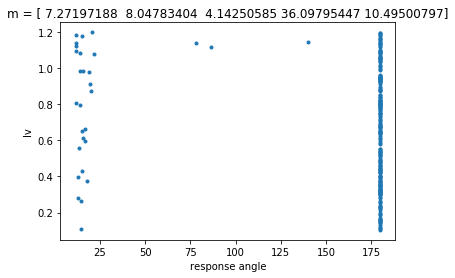

In [228]:
gparams, stats = g.gen(10)
plt.plot(stats[0, 0:246], stats[0, 246:], '.')
plt.xlabel(r'response angle')
plt.ylabel(r'lv')
plt.title('m = ' + str(gparams[1]))

In [305]:
expm_data = np.concatenate((clean_dict['resp_angle'], clean_dict['lv'])).reshape((1, 492))
expm_data.shape

(1, 492)

In [317]:
inf_snpe = SNPE(generator=g, n_components=1, n_hiddens=[500], obs=expm_data)
logs, tds, posteriors = inf_snpe.run(n_train=[5000, 2000], n_rounds=2, epochs=500)
posterior = posteriors[-1]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

KeyboardInterrupt: 

[ 7.07789152 20.68510153 16.15589107 53.00078742 -1.42818228]
[1.]


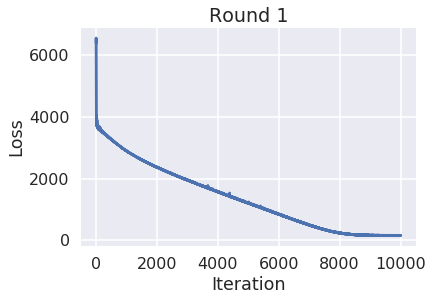

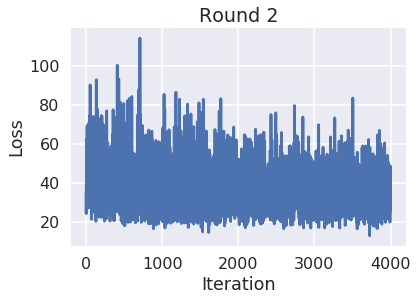

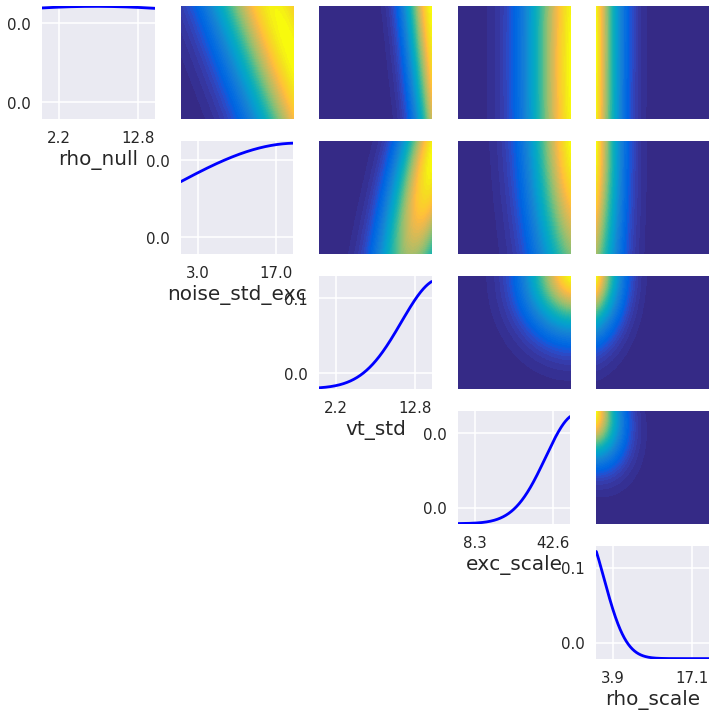

In [316]:
for log_idx, log in enumerate(logs):
    plt.figure()
    plt.plot(log['loss'])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Round ' + str(log_idx+1))

lims = np.array([[0, 15],[0, 20], [0, 15], [1, 50], [1, 20], [0, 5]])
#for comp_idx in range(2):
viz.plot_pdf(posterior.xs[0], lims=lims, labels_params=['rho_null', 'noise_std_exc', 'vt_std', 'exc_scale',
                                                        'rho_scale'],
             figsize=(12,12), ticks=True);
#plt.title('Component ' + str(comp_idx+1))

print(posterior.mean)
print(posterior.a)